In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

In [2]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta2.json')

env = line.env

line['bump.11207'] = 0
line['bump.11407'] = 0
line['bump.11607'] = 0
line['bump.12207'] = 0

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']
line.ref['mdh.12207'].knl[0] += line.vars['bump.12207']

#fix of tidp drift for later insertion of collimator
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36395 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
# Install collimators
tidp_ap_tot = 147
block_mvt = 33
tcsm = xc.EverestCollimator(length=1.83, material = xc.materials.Carbon, gap=5.7)
tidp = xc.EverestCollimator(length=4.3, material = xc.materials.Carbon, jaw_R = -tidp_ap_tot/2 + block_mvt, side = 'right')
line.discard_tracker()
line.collimators.install(names=['tcsm.51932', 'tidp.11434'], elements=[tcsm, tidp])#, at_s=[begin_tidvg, begin_tidvg+2.5, begin_tidvg+3.5, begin_tidvg+4])

Slicing line:   0%|          | 0/75252 [00:00<?, ?it/s]

In [4]:
bump = -5e-3
opt = line.match(
    solve=False,
    start='mdh.11007',
    end='mdhw.11732',
    init=tw, 
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', bump, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw, at='mdhw.11732')
    ]
    )
opt.run_jacobian(10)

                                             
Optimize - start penalty: 0.04974                           
Matching: model call n. 11 penalty = 1.0331e-10              
Optimize - end penalty:  1.03308e-10                            


In [5]:
num_turns = 3000
num_particles = 1000

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

plane = 'H'
amplitude_adt = 0.15
name_sim = '-5mm_bump'

In [6]:
adt = xc.BlowUp.install(line, name=f'adt_{plane}_blowup', at_s=line.get_s_position('adkcv.32171'), plane=plane, stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=True)

line.build_tracker()
tw= line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)
adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)

part = xp.generate_matched_gaussian_bunch(num_particles=num_particles, total_intensity_particles=2.2e11, nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=0.224, line=line)

*** Maximum RMS bunch length 0.23336637795139523m.
... distance to target bunch length: -2.2228e-01
... distance to target bunch length: 4.5424e-03
... distance to target bunch length: 4.3382e-03
... distance to target bunch length: -6.6565e-03
... distance to target bunch length: 2.0203e-03
... distance to target bunch length: -5.7185e-04
... distance to target bunch length: 1.0779e-04
... distance to target bunch length: 4.7891e-06
... distance to target bunch length: -2.0504e-09
... distance to target bunch length: 9.6490e-08
--> Bunch length: 0.22399999794961284
--> Emittance: 0.343668276719016


In [7]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.scattering.enable()
adt.activate()
line.track(part, num_turns=num_turns, time=True, with_progress=1)
adt.deactivate()
line.scattering.disable()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/3000 [00:00<?, ?it/s]

In [8]:
np.unique(part.state, return_counts=True)

(array([-331,    0,    1]), array([620, 288,  92]))

In [9]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu())

ThisLM = xc.LossMap(line, line_is_reversed=False, part=part, interpolation=None)
ThisLM.to_json(file=f'LM_jsons/LM_{name_sim}.json')

In [10]:
import lossmaps as lm

 If you are on SWAN and did not expect this warning, then restart and load the 'NXCals Pro' software stack.


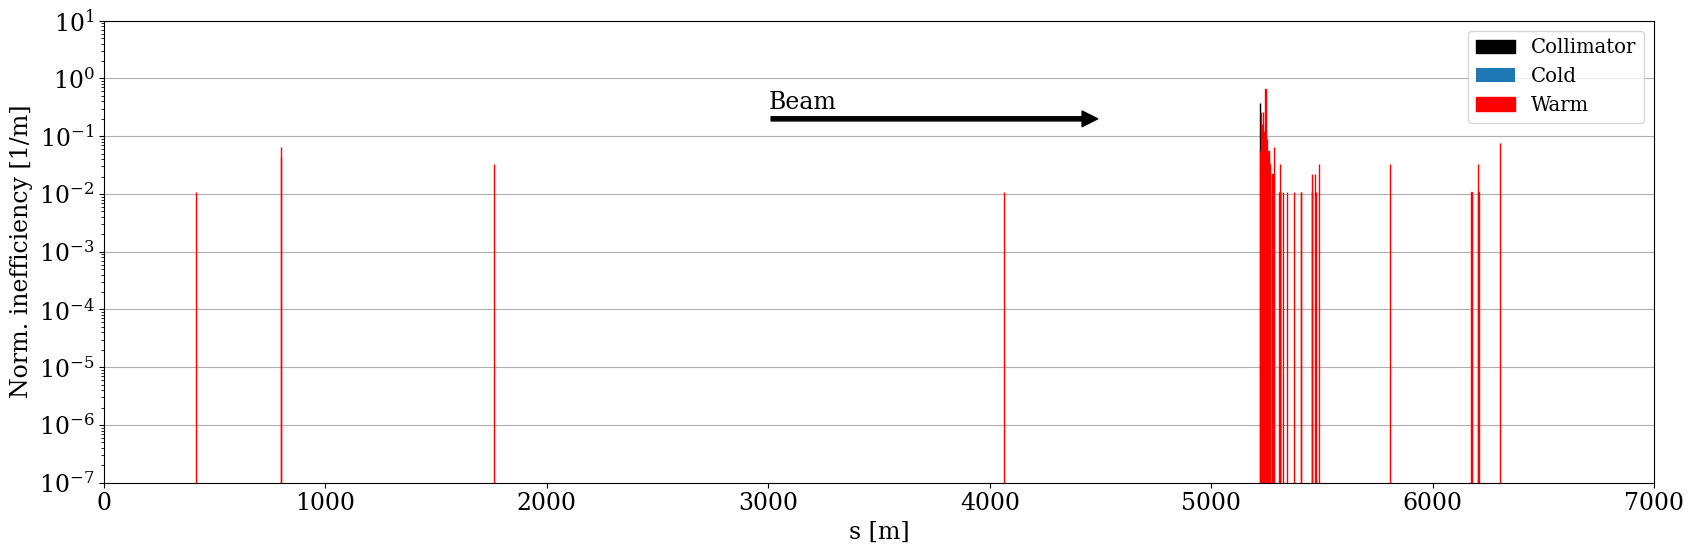

In [12]:
ThisLM = lm.SimulatedLossMap(lmtype=lm.LMType.B1H, machine=lm.Machine.SPS)
ThisLM.load_data_json(json_files=[f'LM_jsons/LM_{name_sim}.json'])
fig = lm.plot_lossmap(ThisLM, xlim=(0,7000), show_zoom=False, outfile=f'{name_sim}.png')
plt.show()